In [15]:
import sys
print(sys.executable)


/opt/campux/virtualenv/deeplearning-u24/bin/python3


In [16]:
import torch
torch.__version__

'2.4.1+cu121'

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device



device(type='cuda')

In [18]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

test_dataset = datasets.MNIST('data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ]))

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=True
)

len(test_dataset)

10000

In [19]:
# Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In [20]:
# Initialize the network
model = Net().to(device)

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
epsilons = [0, .05, .1, .15, .2, .25, .3]

In [29]:
# PGD Attack
# MNIST init
def pgd_attack(model, images, labels, eps=0.3, alpha=2/255, iters=40) :
    images = images.to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()
        
    ori_images = images.data
        
    for i in range(iters) :    
        images = images.detach()
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()
        r=alpha*images.grad.sign()
        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
            
    return images, r


In [22]:
def deepfool(model, image, num_classes=10, overshoot=0.02, max_iter=50):
    """
    image: [1, 1, 28, 28]
    return: x_adv, perturbation (tensor)
    """

    model.eval()
    x = image.clone().detach().to(device)
    x.requires_grad_(True)

    # Initial prediction
    with torch.no_grad():
        logits = model(x)
    label = logits.argmax().item()

    pert_total = torch.zeros_like(x).to(device)

    for _ in range(max_iter):

        # Forward
        logits = model(x)
        preds = logits.argmax().item()
        
        # Stop if model is fooled
        if preds != label:
            break

        # Compute gradient of true class
        logits[0, label].backward(retain_graph=True)
        grad_orig = x.grad.data.clone()

        # Compute perturbations for all other classes
        min_pert = float("inf")
        w_best = None

        for k in range(num_classes):
            if k == label:
                continue

            x.grad.zero_()
            logits[0, k].backward(retain_graph=True)
            grad_k = x.grad.data.clone()

            w_k = grad_k - grad_orig
            f_k = (logits[0, k] - logits[0, label]).item()

            pert_k = abs(f_k) / (w_k.flatten().norm() + 1e-8)

            if pert_k < min_pert:
                min_pert = pert_k
                w_best = w_k

        # Compute minimal perturbation
        r_i = (min_pert + 1e-4) * w_best / (w_best.flatten().norm() + 1e-8)
        pert_total += r_i

        # Update image
        x = (image + (1 + overshoot) * pert_total).detach()
        x.requires_grad_(True)

    x_adv = torch.clamp(x, 0, 1)
    return x_adv.detach(), pert_total.detach()


In [23]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image, epsilon*sign_data_grad

# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

In [32]:
def test( model, device, test_loader ):

    # Accuracy counter
    correct = [0,0,0]
    adv_examples = [[],[],[]]
    count=0

    # Loop over all examples in test set
    for data, target in test_loader:

        count+=1
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = denorm(data)

        # Call PGD Attack
        perturbed_data_pgd = pgd_attack(model,data_denorm,target,eps=0.3, alpha=2/255, iters=40 )
        
        #call FSGM Attack with eps=0.1
        perturbed_data_fsgm = fgsm_attack(data_denorm, 0.1, data_grad)

        #call Deepfool Attack
        perturbed_data_deepfool= deepfool(model, data_denorm)
            

        
        perturbed=[perturbed_data_fsgm[0], perturbed_data_pgd[0],perturbed_data_deepfool[0]]
        
        for i in range(len(perturbed)):
            # Reapply normalization
            perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed[i])
    
            # Re-classify the perturbed image
            output = model(perturbed_data_normalized)
    
            # Check for success
            final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            if final_pred.item() == target.item():
                correct[i] += 1
                
            else:
                # Save some adv examples for visualization later
                if len(adv_examples[i]) < 5:
                    adv_ex = perturbed[i].squeeze().detach().cpu().numpy()
                    adv_examples[i].append( (init_pred.item(), final_pred.item(), adv_ex) )
            
    
    # Calculate final accuracy for each attack
    final_acc = [corr/float(count) for corr in correct]
    
       

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [37]:
from torch.utils.data import DataLoader, Subset


subset100 = Subset(test_dataset, list(range(1000)))  
test_loader100 = DataLoader(subset100, batch_size=1, shuffle=False)
acc, ex = test(model, device, test_loader100)
 

In [50]:
acc,adv_ex=test(model,device, test_loader)

In [54]:
print (acc)

[0.0078, 0.0, 0.1027]


In [51]:
import matplotlib.pyplot as plt
import numpy as np

def show_adv_examples(adv_examples, attack_names=["FGSM", "PGD", "DeepFool"]):
    """
    adv_examples : liste [list_FGSM, list_PGD, list_DeepFool]
    Chaque élément est une liste de tuples : (init_pred, final_pred, adv_image_numpy)
    """

    for attack_id, examples in enumerate(adv_examples):
        
        if len(examples) == 0:
            print(f"No adversarial examples for {attack_names[attack_id]}")
            continue
        
        n = len(examples)
        fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
        if n == 1:
            axes = [axes]

        for i, (init_pred, final_pred, adv_img) in enumerate(examples):

            # adv_img est en format numpy (H,W,C)
            axes[i].imshow(adv_img, cmap=None)
            axes[i].set_title(
                f"{attack_names[attack_id]}\nInit={init_pred} → Final={final_pred}",
                fontsize=12
            )
            axes[i].axis("off")

        plt.tight_layout()
        plt.show()

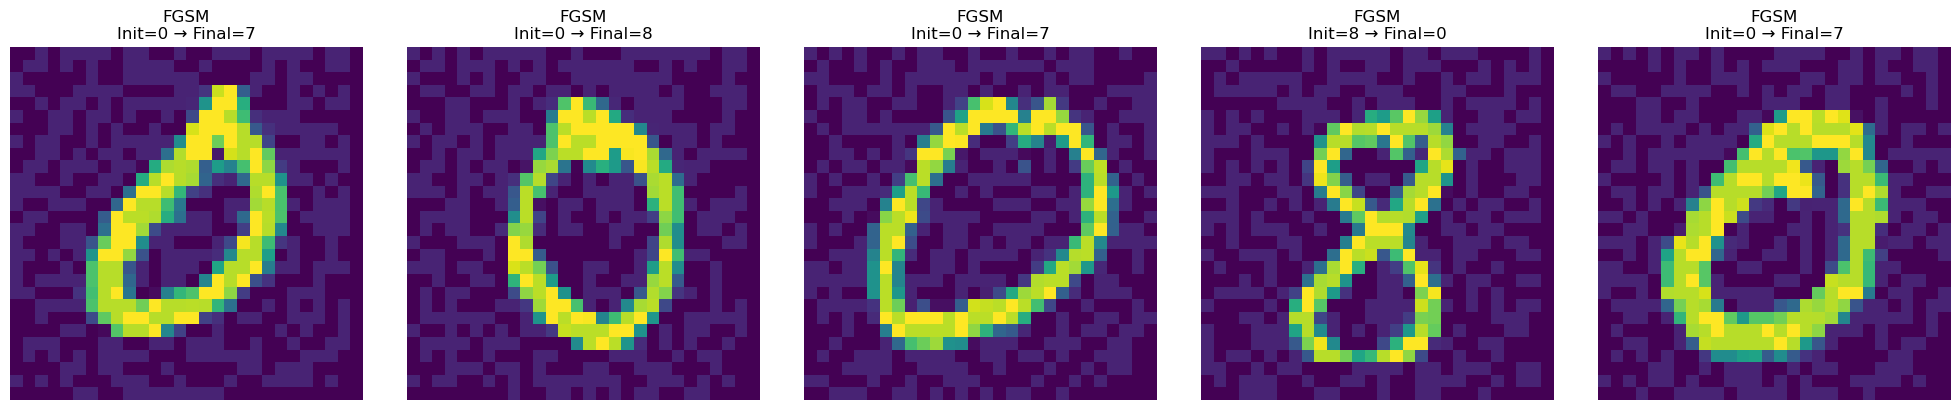

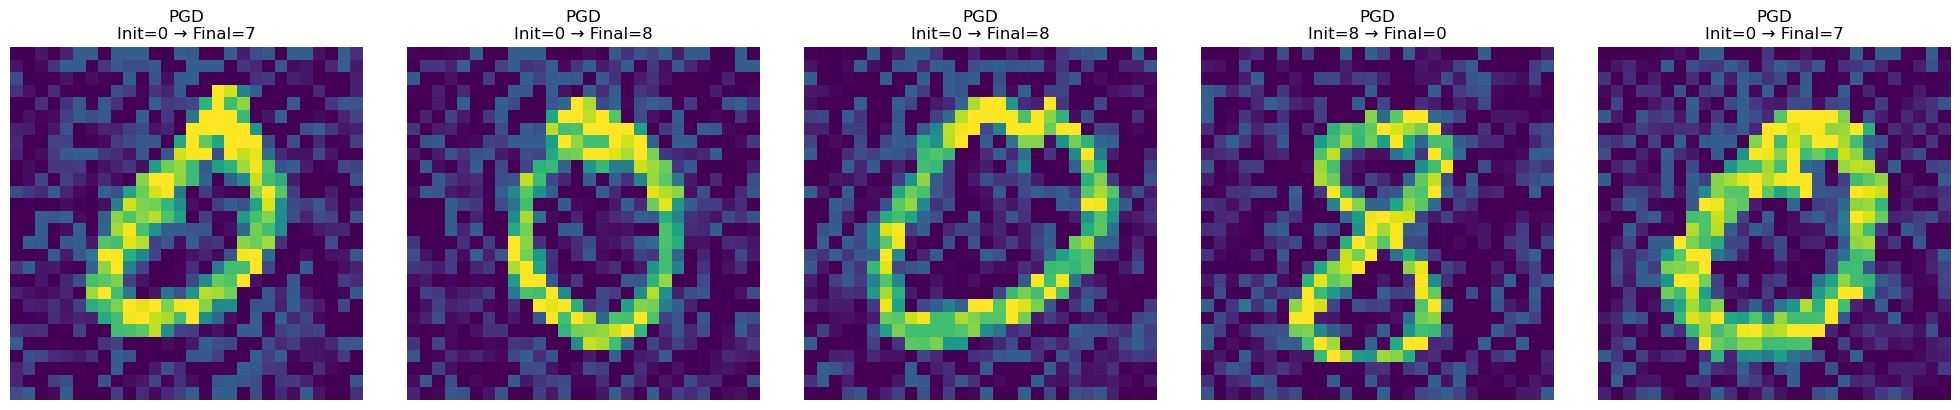

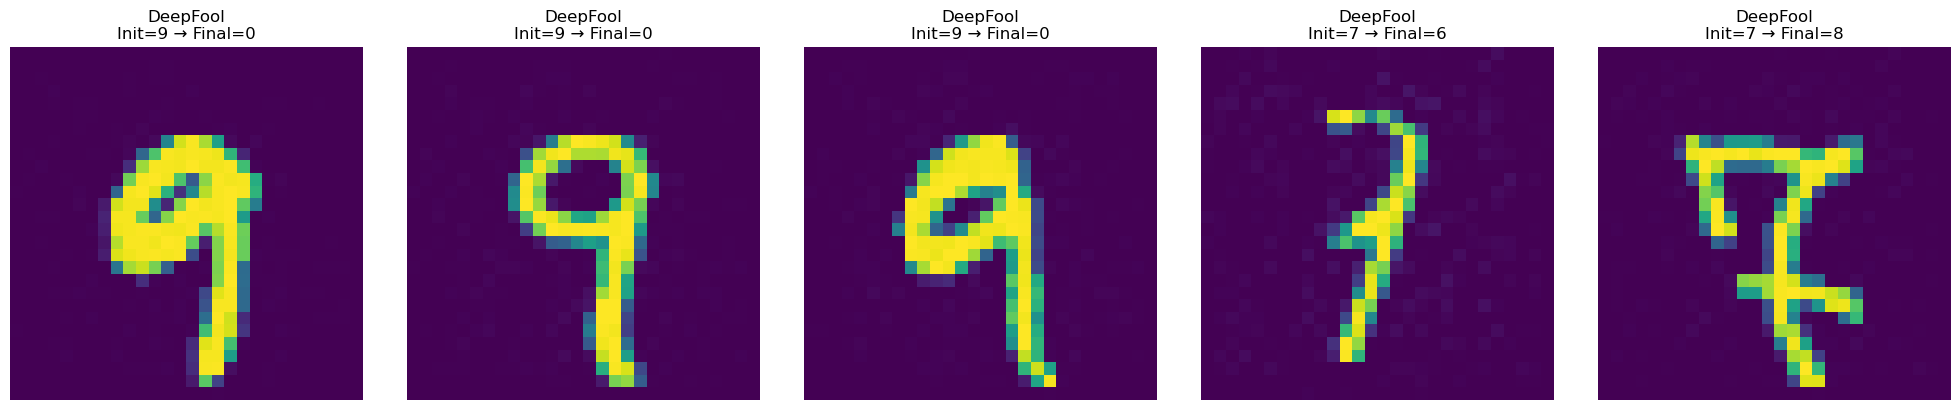

In [53]:
show_adv_examples(adv_ex)